In [ ]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
medium_data = pd.read_csv('/content/sample_data/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...,Part 1: The Risks and Ethical Issues…,453.0,11,9,Towards Data Science,27-01-2023
1,2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...,An alternative approach to understanding bias ...,311.0,3,12,Towards Data Science,27-01-2023
2,3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru...",NaN,188.0,0,24,Towards Data Science,27-01-2023
3,4,https://towardsdatascience.com/dates-and-subqu...,Dates and Subqueries in SQL,Working with dates in SQL,15.0,1,4,Towards Data Science,27-01-2023
4,5,https://towardsdatascience.com/temporal-differ...,Temporal Differences with Python: First Sample...,NaN,10.0,0,13,Towards Data Science,27-01-2023


In [ ]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  2498
Number of fields:  9


In [ ]:
medium_data['title']

0       Not All Rainbows and Sunshine: The Darker Side...
1       Ethics in AI: Potential Root Causes for Biased...
2       Python Tuple, The Whole Truth and Only the Tru...
3                             Dates and Subqueries in SQL
4       Temporal Differences with Python: First Sample...
                              ...                        
2493    Brian Chesky is an Example of What it Means to...
2494                 5 Red Flags of Online Business Gurus
2495    Recognizing These Three Realities Can Help Set...
2496    “I Remember It Like It Was Just Yesterday…” Re...
2497            How to Formulate a Great Nonfiction Theme
Name: title, Length: 2498, dtype: object

In [ ]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))
medium_data['title']

0       Not All Rainbows and Sunshine: The Darker Side...
1       Ethics in AI: Potential Root Causes for Biased...
2       Python Tuple, The Whole Truth and Only the Tru...
3                             Dates and Subqueries in SQL
4       Temporal Differences with Python: First Sample...
                              ...                        
2493    Brian Chesky is an Example of What it Means to...
2494                 5 Red Flags of Online Business Gurus
2495    Recognizing These Three Realities Can Help Set...
2496    “I Remember It Like It Was Just Yesterday…” Re...
2497            How to Formulate a Great Nonfiction Theme
Name: title, Length: 2498, dtype: object

In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  3801
Word: ID
------------
<oov>:  1
Strong:  5
And:  10
Consumption:  1385


In [ ]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  21521


In [ ]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   67,   97, 1336], dtype=int32)

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0   67   97 1336   10 1337    3]
1338
0.0


In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)

Epoch 1/50
673/673 [==============================] - 18s 21ms/step - loss: 6.8272 - accuracy: 0.0551
Epoch 2/50
673/673 [==============================] - 7s 11ms/step - loss: 6.0801 - accuracy: 0.1056
Epoch 3/50
673/673 [==============================] - 7s 10ms/step - loss: 5.5535 - accuracy: 0.1339
Epoch 4/50
673/673 [==============================] - 7s 10ms/step - loss: 5.0024 - accuracy: 0.1668
Epoch 5/50
673/673 [==============================] - 6s 9ms/step - loss: 4.4527 - accuracy: 0.2091
Epoch 6/50
673/673 [==============================] - 7s 10ms/step - loss: 3.9350 - accuracy: 0.2715
Epoch 7/50
673/673 [==============================] - 6s 9ms/step - loss: 3.4576 - accuracy: 0.3439
Epoch 8/50
673/673 [==============================] - 7s 10ms/step - loss: 3.0263 - accuracy: 0.4181
Epoch 9/50
673/673 [==============================] - 6s 9ms/step - loss: 2.6418 - accuracy: 0.4901
Epoch 10/50
673/673 [==============================] - 7s 10ms/step - loss: 2.2980 - accuracy

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

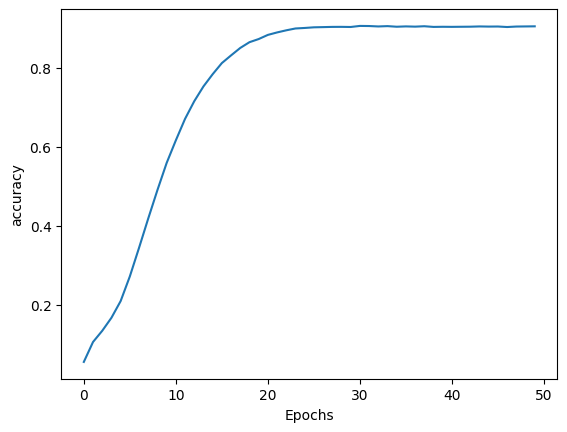

In [ ]:
plot_graphs(history, 'accuracy')

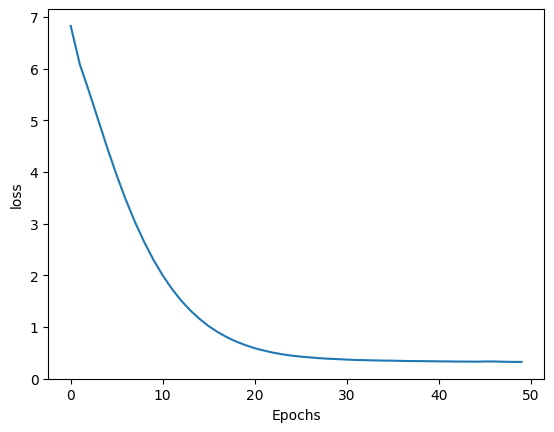

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.model import predict_classes

ModuleNotFoundError: No module named 'tensorflow.keras.model'

In [ ]:
seed_text = "Temporal Differences"
next_words = 2

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 18ms/step
Temporal Differences with python
